In [11]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product, chain, combinations
from scipy import stats
from IPython.display import display, HTML
from datetime import datetime
%matplotlib inline

pd.set_option('display.max_rows',100)
display(HTML("<style>div.output_scroll { height: auto; max-height: 72em; }</style>"))

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

In [12]:
dayframes = {
    (0, 5*60+23): 'NIGHT',
    (5*60+24, 5*60+56): 'TWILIGHT',
    (5*60+57, 20*60+33): 'DAYLIGHT',
    (20*60+34, 21*60+6): 'TWILIGHT',
    (21*60+7, 24*60): 'NIGHT'
}

Detected_Activity_List = {
  0.0 : "IN_VEHICLE",
  1.0 : "ON_BICYCLE",
  2.0 : "ON_FOOT",
  3.0 : "STILL",
  4.0 : "UNKNOWN",
  5.0 : "TILTING",
  7.0 : "WALKING",
  8.0 : "RUNNING"
}

sensor_type_dict = {
    'MONITORING':-1,
    'INDOOR':-2,
    'GPS_SATELLITES':-3,
    'GPS_FIX_SATELLITES':-4,
    'GPS_FIX':-5,
    'DETECTED_ACTIVITY':-6,
    'WIFI_ACCESS_POINTS':-7,
    'BLUETOOTH_DEVICES':-8
}
dayframes

{(0, 323): 'NIGHT',
 (324, 356): 'TWILIGHT',
 (357, 1233): 'DAYLIGHT',
 (1234, 1266): 'TWILIGHT',
 (1267, 1440): 'NIGHT'}

In [13]:
def preprocess_data(inputFile):
    df = pd.read_csv(inputFile)
    df.loc[:,'FileName'] = inputFile
    for index,row in df.iterrows():
        if  df.loc[index,'sensor_type'] == -1:
            df.loc[index,'sensor_type'] = sensor_type_dict[ row['sensor_name']]
    df_wide = df.pivot_table(index=['FileName','timestamp'], columns='sensor_name', values='value', aggfunc='first')
    
    last_seen_values = {}
    sensor_types = df['sensor_name'].unique()
    for sensor_type in sensor_types:
        last_seen_values[sensor_type] = float('nan')

    last_gps_fix = -1
    for index,row in df_wide.iterrows():
        if row['MONITORING'] == 0:
            for sensor_type in sensor_types:
                last_seen_values[sensor_type] = float('nan')
        else:
            if row['GPS_FIX'] > 0:
                last_gps_fix = index[1]
            if last_gps_fix == -1:
                df_wide.loc[index,'GPS_FIX'] = -1
            else:
                df_wide.loc[index, 'GPS_FIX'] = (index[1] - last_gps_fix)/1000
            for sensor_type in sensor_types:
                if math.isnan(row[sensor_type]):
                    df_wide.loc[index,sensor_type] = last_seen_values[sensor_type]
                last_seen_values[sensor_type] = row[sensor_type] 
                if last_seen_values['INDOOR'] == 0.5:
                    print("-->", index)
                
    for index,row in df_wide.iterrows():
        containsNaN = 0.0
        for sensor_type in sensor_types:
            if math.isnan(row[sensor_type]):
                containsNaN = 1.0
                break
        dt = datetime.fromtimestamp(index[1] / 1000)
        minofday = dt.hour * 60 + dt.minute
        for key in dayframes.keys():
            if minofday < key[1] and minofday > key[0]:
                 df_wide.loc[index, 'TIME_OF_DAY'] = dayframes[key]

        df_wide.loc[index,'containsNaN'] = containsNaN

    for value in dayframes.values(): 
        df_wide[value] = df_wide['TIME_OF_DAY'] == value  

    del df_wide['TIME_OF_DAY']

    df_wide = df_wide[(df_wide['MONITORING'] == 1.0) & (df_wide['containsNaN'] == 0.0) & (df_wide['GPS_FIX'] != -1)] 
    del df_wide['containsNaN']

    proximity_name = ""
    light_name = ""
    for sensor_type in sensor_types:
        if 'proximity' in sensor_type.lower():
            proximity_name = sensor_type
            break
        if 'light' in sensor_type.lower():
            light_name = sensor_type

    df_wide.loc[(df_wide[proximity_name] != 0.0),proximity_name] = 1

    for key in Detected_Activity_List.keys(): 
        df_wide[Detected_Activity_List[key]] = df_wide['DETECTED_ACTIVITY'] == key

    df_wide.sort_values(['timestamp'], inplace=True)
    del df_wide['MONITORING']
    del df_wide['DETECTED_ACTIVITY']
    del df_wide['UNKNOWN']
    
    cols = [sensor_type for sensor_type in df_wide.columns.to_list() if sensor_type != proximity_name]
    cols.append(proximity_name)
    df_wide = df_wide[cols].replace(True,1.0).replace(False,0.0)
    df_wide.rename(columns={light_name: "LIGHT", proximity_name: "PROXIMITY"}, inplace=True)
    return df_wide

from os import walk,path

dfs = []
root_directory = "datasets"
_, _, filenames = next(walk(root_directory))
for filename in filenames:
    print(filename)
    x = path.join(root_directory,filename)
    dfs.append(preprocess_data(x))
    

df_wide = pd.concat(dfs)
    

df_wide

collected-data_D.csv
collected-data_N_1.csv
collected-data_N_2.csv
collected-data_R.csv
collected-data_Z_2.csv
collected-data_Z_3.csv
collected-data_Z_4.csv
collected-data_Z_5.csv
test-data_N.csv


sensor_name                                  BLUETOOTH_DEVICES  GPS_FIX  \
FileName                      timestamp                                   
datasets\collected-data_D.csv 1620830531673                1.0    7.319   
                              1620830531926                1.0    7.572   
                              1620830532100                1.0    7.746   
                              1620830533100                1.0    8.746   
                              1620830534110                1.0    9.756   
...                                                        ...      ...   
datasets\test-data_N.csv      1620991940601                0.0   24.876   
                              1620991941092                0.0   25.367   
                              1620991942786                0.0   27.061   
                              1620991943641                0.0   27.916   
                              1620991945123                0.0   29.398   

sensor_name                                  GPS_FIX_SATELLITES  \
FileName                      timestamp                           
datasets\collected-data_D.csv 1620830531673                14.0   
                              1620830531926                14.0   
                              1620830532100                14.0   
                              1620830533100                14.0   
                              1620830534110                14.0   
...                                                         ...   
datasets\test-data_N.csv      1620991940601                 0.0   
                              1620991941092                 0.0   
                              1620991942786                 0.0   
                              1620991943641                 0.0   
                              1620991945123                 0.0   

sensor_name                                  GPS_SATELLITES  INDOOR   LIGHT  \
FileName                      timestamp                                       
datasets\collected-data_D.csv 1620830531673            25.0     0.0  1927.0   
                              1620830531926            25.0     0.0  1927.0   
                              1620830532100            25.0     0.0  1009.0   
                              1620830533100            25.0     0.0  1064.0   
                              1620830534110            25.0     0.0   954.0   
...                                                     ...     ...     ...   
datasets\test-data_N.csv      1620991940601            35.0     1.0    11.0   
                              1620991941092            35.0     1.0    11.0   
                              1620991942786            35.0     1.0    11.0   
                              1620991943641            35.0     0.0    11.0   
                              1620991945123            35.0     0.0     8.0   

sensor_name                                  WIFI_ACCESS_POINTS  NIGHT  \
FileName                      timestamp                                  
datasets\collected-data_D.csv 1620830531673                 1.0    0.0   
                              1620830531926                 1.0    0.0   
                              1620830532100                 1.0    0.0   
                              1620830533100                 1.0    0.0   
                              1620830534110                 1.0    0.0   
...                                                         ...    ...   
datasets\test-data_N.csv      1620991940601                 5.0    0.0   
                              1620991941092                 5.0    0.0   
                              1620991942786                 5.0    0.0   
                              1620991943641                 5.0    0.0   
                              1620991945123                 5.0    0.0   

sensor_name                                  TWILIGHT  DAYLIGHT  IN_VEHICLE  \
FileName                      timestamp                                       
dat

In [14]:
df_wide['INDOOR'].value_counts()

0.0    19242
1.0    14467
Name: INDOOR, dtype: int64

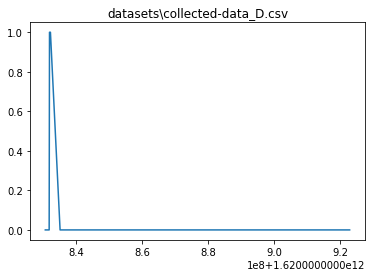

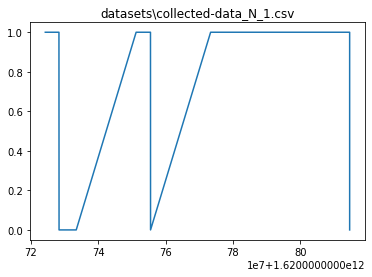

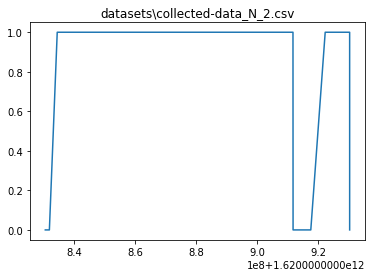

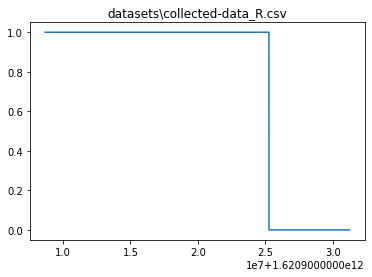

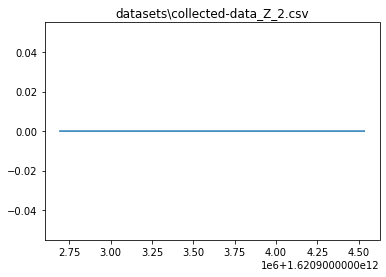

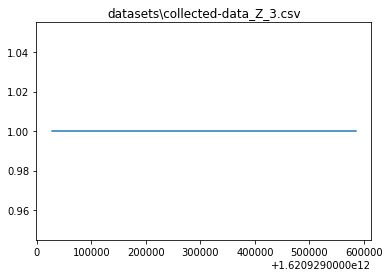

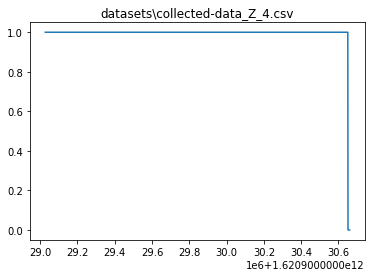

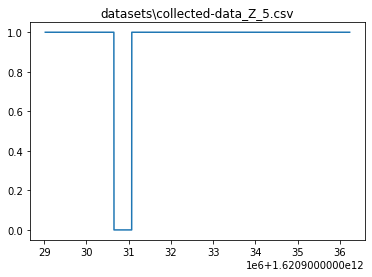

In [15]:
last_filename = None
time = []
indoor = []
for index,row in df_wide.iterrows():
    filename = index[0]
    if last_filename == None:
        last_filename = filename
    if last_filename != filename:
        plt.plot(time,indoor)
        plt.title(last_filename)
        plt.show()
        plt.close()
        time = []
        indoor = []
        last_filename = filename
    time.append(index[1])
    indoor.append(row['INDOOR'])

In [16]:
descb = df_wide.describe()
descb.to_csv('descb.csv')

In [17]:
cols = ['BLUETOOTH_DEVICES','GPS_FIX','GPS_FIX_SATELLITES','GPS_SATELLITES','LIGHT','WIFI_ACCESS_POINTS']

for col in cols:
    colMin = df_wide[col].min()
    colMax = df_wide[col].max()
    df_wide[col] = df_wide[col].apply(lambda x: (x - colMin)/(colMax - colMin))
    
df_wide.to_csv('preprocessed_data.csv')